In [1]:
import functools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from typing import Dict, Any, Optional, List, Tuple
from transformers import pipeline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/cmu-stuff/2025-spring/14795_AI_Infosec/final_project/project_code

/content/drive/MyDrive/cmu-stuff/2025-spring/14795_AI_Infosec/final_project/project_code


In [4]:
dataset = pd.read_csv("data/data_50k.csv")

## NLTK-based word frequency inspection

In [5]:
reshaped = []

for idx in range(len(dataset)):
  row = dataset.iloc[idx]

  reshaped.append({
      "text": row["human_text"],
      "is_human": True,
      "length": row["human_text_length"]
  })

  reshaped.append({
      "text": row["ai_text"],
      "is_human": False,
      "length": row["ai_text_length"]
  })

df_reshaped = pd.DataFrame(reshaped)

display(df_reshaped.head(10))


,text,is_human,length
0,nothing is impossible to go better to better.....,True,1014
1,"This will help to refresh your memory, as well...",False,1610
2,"Another example, some students are really quie...",True,2158
3,"When faced with a challenging problem, the ind...",False,941
4,Also be in a group helps to perform our skills...,True,1824
5,"On the other hand, one of the disadvantages of...",False,879
6,"It brings optimism into your life, and makes i...",True,1812
7,\nHaving a positive attitude is a powerful too...,False,706
8,"For example, I have Personal Fitness on my las...",True,1600
9,This shift in focus can also help de-emphasize...,False,859


In [6]:
len(df_reshaped)

100000

In [7]:
df_sample = df_reshaped.sample(100)

In [8]:
classifier = pipeline(
    "zero-shot-classification", model="facebook/bart-large-mnli", device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


In [9]:
# LLM Tags generated by LLM
# Prompt: Generate a list of features in english text that differentiates between human text and LLM-generated text,
# I need to use these features in a Zero-Shot BART model. Output as a python list
features = [
    "lexical_diversity",              # Variety in word choice and vocabulary richness
    "sentence_length_variation",      # Natural variation in how sentences are structured
    "use_of_idioms_and_colloquialisms", # Naturally occurring figurative language
    "contextual_inconsistencies",     # Occasional logical gaps or contextual errors
    "hedge_word_frequency",           # Words like "perhaps," "maybe," "possibly"
    "specificity_of_examples",        # Concrete vs. generic examples
    "emotional_expression_variation", # Natural fluctuations in emotional tone
    "self_reference_frequency",       # Personal experiences and first-person language
    "topic_drift_patterns",           # Natural tangents and shifts in focus
    "digression_patterns"             # Side notes and conversational wandering
]

In [10]:
class AiData(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data = df["text"].tolist()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [11]:
idx = 0
n_entries = 1024
label_rows = []
h_batch_size = 384
diff = 0

sample_sm = df_reshaped.sample(n_entries)
data = AiData(sample_sm)

input_columns = list(df_reshaped.columns)

for r in classifier(data, features, batch_size=h_batch_size):

    print(f"\rPROGRESS: {idx + 1} / {n_entries}", end="")
    row = [r["sequence"]]

    for c in features:
        row.append(r["scores"][r["labels"].index(c)])

    for c in input_columns:
        if c == "text":
            continue
        row.append(sample_sm[c].iloc[idx])

    label_rows.append(row)
    idx += 1

    # Purge cache once in a while
    if idx - diff > h_batch_size * 8:
        torch.cuda.empty_cache()
        diff = idx


other_cols = [c for c in input_columns if c != "text"]

df_labels = pd.DataFrame(label_rows, columns=["text"] + features + other_cols)
df_labels.to_csv(f"labels.csv", index=False)

PROGRESS: 1024 / 1024

In [12]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [13]:
df_labels

,text,lexical_diversity,sentence_length_variation,use_of_idioms_and_colloquialisms,contextual_inconsistencies,hedge_word_frequency,specificity_of_examples,emotional_expression_variation,self_reference_frequency,topic_drift_patterns,digression_patterns,is_human,length
0,Thomas Jefferson Prompt\n\nThomas Jefferson on...,0.089974,0.110001,0.119989,0.109690,0.094069,0.095447,0.100550,0.091502,0.098797,0.089983,True,2702
1,When am working like to listen to music becaus...,0.055977,0.082926,0.119951,0.180808,0.048013,0.126204,0.141151,0.070042,0.065018,0.109910,True,3634
2,"On the other, our assumptions may be limited o...",0.087693,0.105497,0.089996,0.090172,0.102172,0.099073,0.094836,0.115499,0.106275,0.108787,False,656
3,Humans' relay on other's for their own achieve...,0.059478,0.098170,0.173236,0.089363,0.087149,0.070290,0.144151,0.102963,0.086191,0.089008,True,1830
4,Some may disagree with this because others may...,0.096676,0.069808,0.077988,0.117642,0.075848,0.130280,0.113256,0.118607,0.098909,0.100986,True,2981
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,And they will never grow becuase people star d...,0.041396,0.074411,0.169176,0.161785,0.084426,0.104253,0.092580,0.088480,0.081987,0.101505,True,1792
1020,Approaching customers with a positive attitude...,0.081295,0.058143,0.070997,0.123575,0.122654,0.088913,0.120363,0.144606,0.095911,0.093542,True,855
1021,First I will like to change lunch manu I would...,0.063389,0.109261,0.084409,0.146436,0.065146,0.135232,0.092193,0.116645,0.085505,0.101784,True,980
1022,"We will explore actionable solutions, such as ...",0.068110,0.067877,0.090492,0.192849,0.102413,0.105447,0.084867,0.083558,0.088056,0.116330,False,721


In [14]:
df_labels["is_human"].value_counts()

,count
is_human,
False,520
True,504


In [15]:
df_model = df_labels.drop(columns=["text"])

In [21]:
# Do a 30/70 split
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_model, test_size=0.3, random_state=114514)

In [23]:
# prompt: with is_human being the label, train a XGBoost model on df_train

import xgboost as xgb
from sklearn.metrics import accuracy_score

# Define features (X) and target (y)
X_train = df_train.drop(columns=['is_human'])
y_train = df_train['is_human']
X_test = df_test.drop(columns=['is_human'])
y_test = df_test['is_human']

# Initialize and train the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)



Accuracy: 0.8441558441558441


              precision    recall  f1-score   support

       False       0.79      0.90      0.85       145
        True       0.90      0.79      0.84       163

    accuracy                           0.84       308
   macro avg       0.85      0.85      0.84       308
weighted avg       0.85      0.84      0.84       308



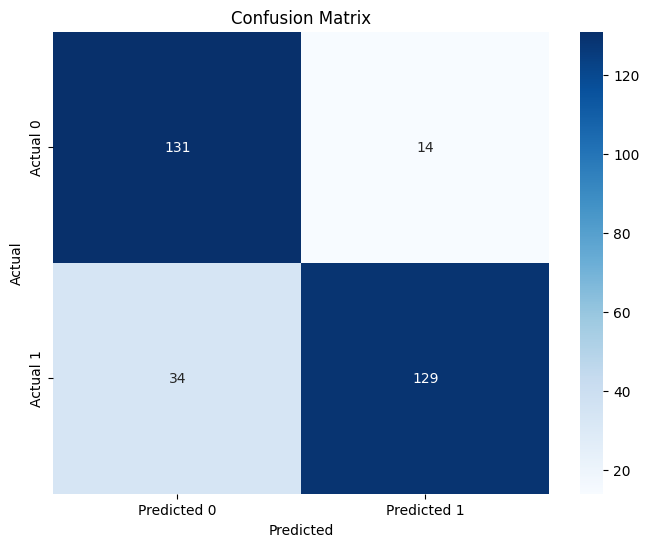

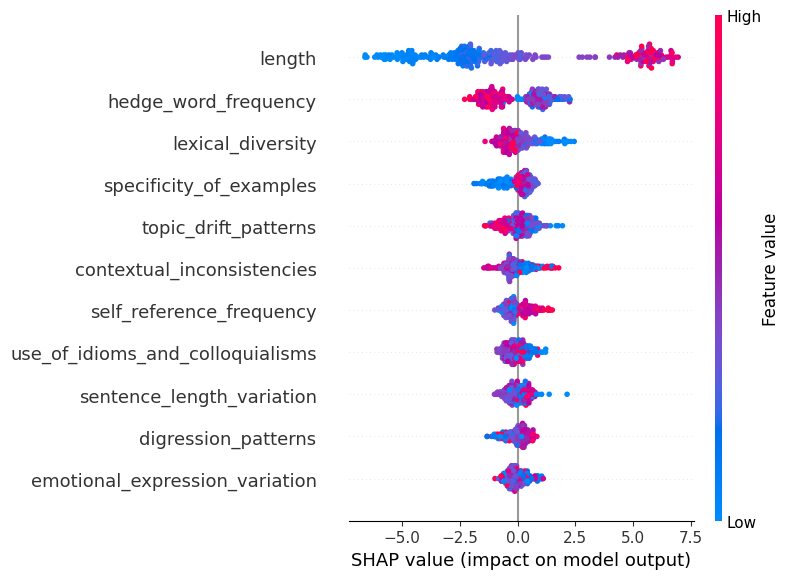

In [24]:
# prompt: Based on y_pred and y_test, generate a comprehensive model performance report with pandas, scikit-learn, and seaborn. And use SHAP to explore explainability

import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# Generate classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# SHAP values for explainability
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Dependence plot (example for one feature)
# Replace 'feature_name' with an actual feature name from your dataset.
# shap.dependence_plot('feature_name', shap_values.values, X_test)

# Force plot (example for a specific instance)
# Replace 'instance_index' with the index of the instance you want to examine.
# shap.force_plot(explainer.expected_value, shap_values.values[instance_index,:], X_test.iloc[instance_index,:])
